Below are some basic analyses that can be done with the NHANES data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load the data.  We will work with the 2015-2016 NHANES wave here.

In [2]:
pa = "https://raw.githubusercontent.com/kshedden/statswpy-nhanes/master/merged/nhanes_2015_2016.csv"
df = pd.read_csv(pa)

Check what columns we have:

In [3]:
df.columns

Index(['SEQN', 'ALQ101', 'ALQ110', 'ALQ130', 'SMQ020', 'RIAGENDR', 'RIDAGEYR',
       'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 'INDFMPIR',
       'BPXSY1', 'BPXDI1', 'BPXSY2', 'BPXDI2', 'BMXWT', 'BMXHT', 'BMXBMI',
       'BMXLEG', 'BMXARML', 'BMXARMC', 'BMXWAIST', 'HIQ210'],
      dtype='object')

Determine the number of non-missing values for each variable:

In [4]:
pd.notnull(df).sum(0)

SEQN        5735
ALQ101      5208
ALQ110      1731
ALQ130      3379
SMQ020      5735
RIAGENDR    5735
RIDAGEYR    5735
RIDRETH1    5735
DMDCITZN    5734
DMDEDUC2    5474
DMDMARTL    5474
DMDHHSIZ    5735
INDFMPIR    5134
BPXSY1      5401
BPXDI1      5401
BPXSY2      5535
BPXDI2      5535
BMXWT       5666
BMXHT       5673
BMXBMI      5662
BMXLEG      5345
BMXARML     5427
BMXARMC     5427
BMXWAIST    5368
HIQ210      4732
dtype: int64

Recode some of the categorical variables to use text labels instead of numeric codes:

In [5]:
df.RIAGENDR = df.RIAGENDR.replace({1: "M", 2: "F"})
df.DMDMARTL = df.DMDMARTL.replace({1: "Mar", 2: "Wid", 3: "Div", 4: "Sep", 5: "Nev", 6: "Liv", 77: "Ref", 99: "DK"})
df.ALQ101 = df.ALQ101.replace({1: "Y", 2: "N", 9: "DK"})

For a quantitative variable, we can obtain summary statistics with "describe":

In [6]:
df.BMXBMI.describe()

count    5662.000000
mean       29.382197
std         7.095921
min        14.500000
25%        24.300000
50%        28.300000
75%        33.000000
max        67.300000
Name: BMXBMI, dtype: float64

For a nominal variables, we can obtain the frequency distribution over the categories using "value_counts":

In [7]:
df.DMDMARTL.value_counts()

Mar    2780
Nev    1004
Div     579
Liv     527
Wid     396
Sep     186
Ref       2
Name: DMDMARTL, dtype: int64

We can make a contingency table looking at the number of people in each gender x marital status category:

In [8]:
pd.crosstab(df.RIAGENDR, df.DMDMARTL)

DMDMARTL,Div,Liv,Mar,Nev,Ref,Sep,Wid
RIAGENDR,,,,,,,
F,350,262,1303,520,1,118,296
M,229,265,1477,484,1,68,100


We can take the table of frequencies and normalize it by row, so we get estimated probability distributions of marital status groups for women and for men.  The proportions are quite similar between the genders, except that women are much more likely to be widowed than men (this is mainly due to the fact that women live longer than men on average).

In [9]:
pd.crosstab(df.RIAGENDR, df.DMDMARTL, normalize="index")

DMDMARTL,Div,Liv,Mar,Nev,Ref,Sep,Wid
RIAGENDR,,,,,,,
F,0.122807,0.091930,0.457193,0.182456,0.000351,0.041404,0.10386
M,0.087271,0.100991,0.562881,0.184451,0.000381,0.025915,0.03811


Body dimensions tend to be correlated.  For example, below we see that leg length and arm length are strongly correlated.

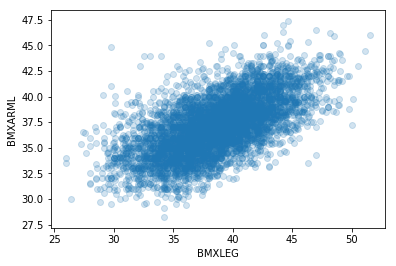

In [10]:
sns.regplot(x="BMXLEG", y="BMXARML", data=df, fit_reg=False, scatter_kws={"alpha": 0.2})

However BMI and height are only weakly (negatively) correlated.  This low correlation is largely a result of the way that BMI is defined.  It is intended to be a measure of obesity that has the same scale across all levels of height.

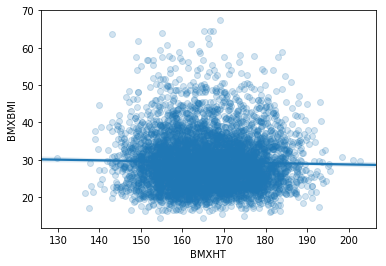

In [11]:
sns.regplot(x="BMXHT", y="BMXBMI", scatter_kws={"alpha": 0.2}, data=df)

Among younger people, taller people tend to have higher blood pressure than shorter people.  This effect is attenuated or reversed in older people.

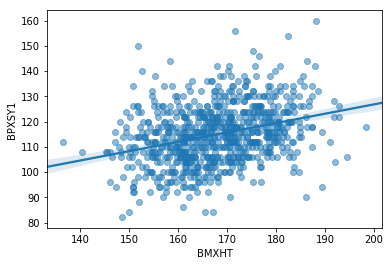

In [12]:
dx = df.loc[(df.RIDAGEYR>20) & (df.RIDAGEYR<30), :]
sns.regplot(dx.BMXHT, dx.BPXSY1, scatter_kws={"alpha": 0.5})

Among young females, people with more education tend to have lower BMI:

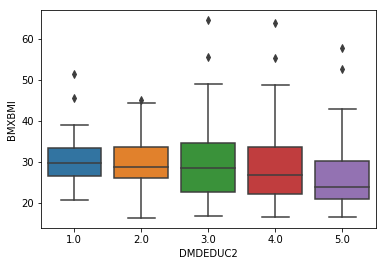

In [13]:
dx = df.loc[(df.RIDAGEYR>20) & (df.RIDAGEYR<30) & (df.RIAGENDR=="F"), :]
sns.boxplot(x="DMDEDUC2", y="BMXBMI", data=dx)

But this trend is less evident among young men:

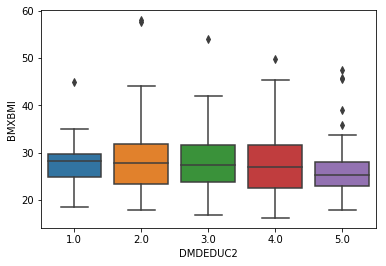

In [14]:
dx = df.loc[(df.RIDAGEYR>20) & (df.RIDAGEYR<30) & (df.RIAGENDR=="M"), :]
sns.boxplot(x="DMDEDUC2", y="BMXBMI", data=dx)

Below is a plot showing the distribution of systolic blood pressure by age and gender.  As expected, older people have higher blood pressures than younger people.  We also see that older peoples' blood pressures are more dispersed than those of younger people.  Among younger people, men have substantially higher blood pressure than women on average.  But this effect reverses for older people.  This is partly due to men with hypertension dying early, leaving a relatively healthier population of older men.

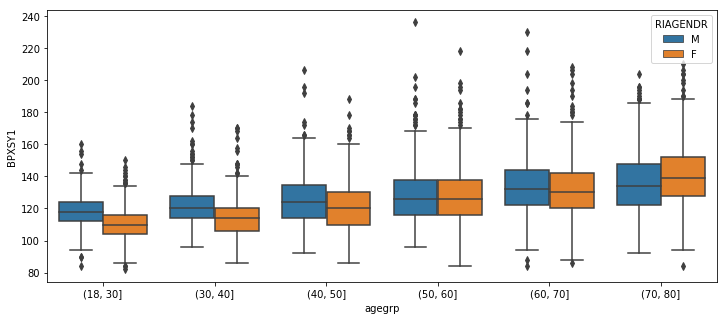

In [15]:
df["agegrp"] = pd.cut(df.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
plt.figure(figsize=(12, 5))
sns.boxplot(x="agegrp", y="BPXSY1", hue="RIAGENDR", data=df)

We can graph the proportion of "ever smokers" (people who state that they smoked at least 100 cigarettes in their life), by gender and age.  We see that in the US, more men have smoked than women, and older people are much more likely to have smoked than younger people.

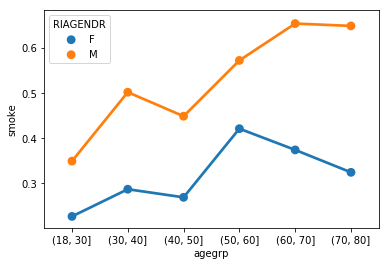

In [16]:
df["smoke"] = (df.SMQ020 == 1).astype(np.int)
ds = df.groupby(["agegrp", "RIAGENDR"])["smoke"].agg(np.mean)
ds = ds.reset_index()
sns.pointplot(x="agegrp", y="smoke", hue="RIAGENDR", data=ds)

Body dimensions tend to be correlated.  For example, weight and arm circumference are very strongly correlated (>0.9).   

In [18]:
da = dx[["BMXHT", "BMXWT", "BMXBMI", "BMXARMC", "BMXARML", "BMXWAIST"]].dropna()
da.corr()

,BMXHT,BMXWT,BMXBMI,BMXARMC,BMXARML,BMXWAIST
BMXHT,1.000000,0.346220,0.001760,0.215076,0.725766,0.128944
BMXWT,0.346220,1.000000,0.935078,0.900944,0.458201,0.939465
BMXBMI,0.001760,0.935078,1.000000,0.879586,0.216229,0.952878
BMXARMC,0.215076,0.900944,0.879586,1.000000,0.407219,0.826103
BMXARML,0.725766,0.458201,0.216229,0.407219,1.000000,0.311157
BMXWAIST,0.128944,0.939465,0.952878,0.826103,0.311157,1.000000


We can form quite narrow strata by considering the joint status of gender, education, and marital status.  Then we can look at the mean BMI within each cell of this table.  Since some of the cell counts can get quite small here, to focus we consider only divorced and currently married people. Also, since age is strongly associated with blood pressure, we limit toa fairly narrow age band.  One interesting trend here is that for highly educated men and women, divorced people tend to have higher BMIs than married people, but among men and women with the lowest levels of education, the married people tend to have greater BMI than the divorced people.

In [40]:
dx = df.loc[(df.DMDEDUC2<=5) & df.DMDMARTL.isin(["Div", "Mar"])& (df.RIDAGEYR >= 40) & (df.RIDAGEYR <= 50)]
dx.groupby(["RIAGENDR", "DMDEDUC2", "DMDMARTL"]).agg({"BMXBMI": np.mean}).unstack()

BMXBMI           
DMDMARTL                 Div        Mar
RIAGENDR DMDEDUC2                      
F        1.0       24.300000  29.378571
         2.0       35.440000  31.716667
         3.0       29.378571  30.636957
         4.0       32.842424  32.365909
         5.0       30.360000  27.716239
M        1.0       23.200000  27.742424
         2.0       26.587500  29.075676
         3.0       27.537500  30.339286
         4.0       31.226667  30.546575
         5.0       32.516667  28.245714